## Reprojecting and Resampling

In this tutorial, you'll learn how to reproject [Cloud Optimized GeoTIFFs](https://www.cogeo.org/) (COG) into a different [Coordinate Reference System](https://gdal.org/tutorials/osr_api_tut.html) (CRS). Reprojecting data usually also includes resampling the raster data to a different resolution, which requires combining multiple pixel values into (when downsampling -- or resampling to lower resolution/larger cellsizes) or interpolating new pixels from the existing ones (when upsampling -- or resampling to higher resolution/smaller cellsizes). You will also learn how to use different resampling algorithms to adjust the raster pixel size.

This tutorial covers several methods for reprojecting. Which one to pick depends primarily on two factors: 

* whether you already know what CRS you are targeting when you load your data
* whether you have [STAC Items](https://github.com/radiantearth/stac-spec/blob/master/overview.md#item-overview) for the data you're working with

In general, reprojecting and resampling while loading the data is more efficient, and all the remote-sensing datasets in the [Planetary Computer's data catalog](https://planetarycomputer.microsoft.com/catalog) include STAC Items.

This tutorial covers the following four methods for reprojecting and resampling geodata:

* [Method 1](#Method-1:-Reproject-and-resample-while-loading-with-stackstac.stack): **Reproject and resample a large number of COGs *while loading*** using [stackstac](https://stackstac.readthedocs.io/en/latest/). This method requires STAC items.
* [Method 2](#Method-2:-Reproject-and-resample-while-loading-with-rasterio-and-rioxarray-using-a-WarpedVRT): **Reproject and resample a single COG *while loading*** with [rioxarray](https://corteva.github.io/rioxarray/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) using a [WarpedVRT](https://rasterio.readthedocs.io/en/latest/topics/virtual-warping.html). This option works without STAC items but won't scale to a large number of COGs.
* [Method 3](#Method-3:-Reproject-and-resample-an-in-memory-array-with-stackstac.reproject_array): **Reproject and resample an *in-memory* (potentially distributed) DataArray** with [`stackstac.reproject_array`](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.reproject_array.html). This option requires more memory and is generally less efficient than option 1, but you don't need to know the destination CRS when loading your data.
* [Method 4](#Method-4:-Reproject-and-resample-an-in-memory-DataArray-with-rasterio-and-rioxarray): **Reproject and resample an *in-memory* (single machine) DataArray** using [rioxarray](https://corteva.github.io/rioxarray/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/index.html). This option only works on a single machine and requires more memory than option 2, but you don't need to know the destination CRS when loading your data.

These reprojection methods are ranked in order of what is generally recommended. However, certain methods may not be available depending on whether you know your destination CRS while loading the data and whether you have STAC Items.

In [1]:
import planetary_computer as pc
import pystac_client

import numpy as np
import xarray as xr

import stackstac
import affine
import pyproj
import rioxarray
import rasterio

from rioxarray.rioxarray import _make_coords
from rasterio.vrt import WarpedVRT

import xrspatial.multispectral as ms
import matplotlib.pyplot as plt

### Preparation: Create a local Dask cluster

In this tutorial, you'll be using a small dataset. Create a local Dask cluster to process the data in parallel using all the cores of your machine.

In [2]:
from dask.distributed import Client

client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


To follow the progress of your computation, you can [access the Dask Dashboard](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/#Open-the-dashboard) at the URL from the previous cell's output.

The region of interest for this tutorial is located in Colorado, USA, centered by Cochetopa Dome and Sawtooth Mountain. You'll be using [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data. See [Reading data from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) for more information on accessing data through the STAC API.

In [3]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1/")
search = stac.search(
    collections=["sentinel-2-l2a"],
    intersects={"type": "Point", "coordinates": [-106.714900, 38.22679]},
    query={"eo:cloud_cover": {"lt": 1}},
    datetime="2019-09-01/2019-09-30",
)

item = next(search.get_items())
signed_item = pc.sign(item)

### Method 1: Reproject and resample while loading with [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html)

The selected scene is stored in an `EPSG:32613` coordinate system. Let's reproject it to a new CRS by providing the destination `epsg` number to the [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html) function. To adjust the data's resolution, also provide values to the function's optional `resolution` and `resampling` parameters.

With `stackstac.stack`, you can use any CRS as defined by an [EPSG code](http://epsg.io/). In this example, you use the `stackstac.stack` function to reproject to the Lambert Cylindrical projection (`epsg:6933`). [Lambert Cylindrical](https://en.wikipedia.org/wiki/Lambert_cylindrical_equal-area_projection) is an equal-area projection that preserves area measurements. Regions with the same size on the Earth's surface have the same size on the map. However, shapes, angles, and scales are generally distorted.

This example uses the [bilinear](https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling.bilinear) resampling method. Resampling happens in the `stackstac.stack` function as well. As this function uses [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) internally, you can use any algorithm from the [rasterio.enums.Resampling](https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling) class. To use a specific algorithm, pass it as a value for the `resampling` parameter. The default resampling method in `stackstac.stack` is `rasterio.enums.Resampling.nearest`.

In [4]:
scene_data = (
    stackstac.stack(
        [signed_item.to_dict()],
        epsg=6933,
        resampling=rasterio.enums.Resampling.bilinear,
        resolution=100,  # resolution in the output CRS’s units
        assets=["B04", "B03", "B02"],  # red, green, blue bands
        chunksize=2048,
    )
    .isel(time=0)
    .persist()
)

scene_data

<xarray.DataArray 'stackstac-70964429577d6f8e4004178ae459a9c1' (band: 3, y: 995, x: 1235)>
dask.array<getitem, shape=(3, 995, 1235), dtype=float64, chunksize=(1, 995, 1235), chunktype=numpy.ndarray>
Coordinates: (12/46)
    time                                     datetime64[ns] 2019-09-24T17:50:...
    id                                       <U54 'S2B_MSIL2A_20190924T175049...
  * band                                     (band) <U3 'B04' 'B03' 'B02'
  * x                                        (x) float64 -1.035e+07 ... -1.02...
  * y                                        (y) float64 4.591e+06 ... 4.491e+06
    s2:product_type                          <U7 'S2MSI2A'
    ...                                       ...
    proj:transform                           object {0.0, 300000.0, 10.0, 430...
    proj:bbox                                object {300000.0, 4190220.0, 430...
    common_name                              (band) <U5 'red' 'green' 'blue'
    center_wavelength                        (band) float64 0.665 0.56 0.49
    full_width_half_max                      (band) float64 0.038 0.045 0.098
    epsg                                     int64 6933
Attributes:
    spec:        RasterSpec(epsg=6933, bounds=(-10353400, 4491300, -10229900,...
    crs:         epsg:6933
    transform:   | 100.00, 0.00,-10353400.00|\n| 0.00,-100.00, 4590800.00|\n|...
    resolution:  100

To generate a preview of the reprojected and resampled data, create a true color image with the [xrspatil.multispectral.true_color](https://xarray-spatial.org/reference/_autosummary/xrspatial.multispectral.true_color.html) function. 

Provide the following parameters:
* the three bands of `red`, `green`, `blue` in your `scene_data`
* the optional string value `name` for the image's name

Note: To adjust contrast and brightness, provide values for the two optional numeric parameters `c` (contrast) and `th` (brightness). All image previews in this tutorial use the function's default values of `c=10` and `th=0.125`.

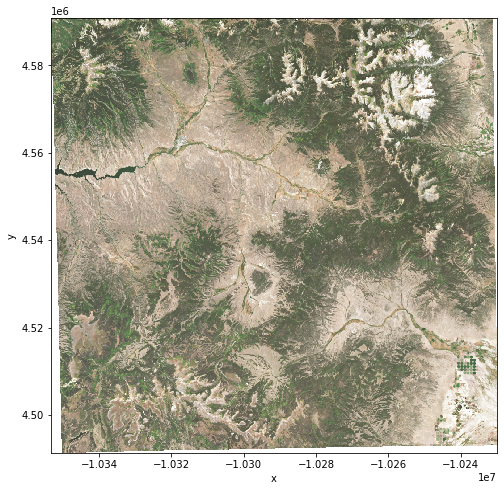

In [5]:
# visualize selected scene
cylindrical_img = ms.true_color(*scene_data, name="epsg=6933")
cylindrical_img.plot.imshow(figsize=(8, 8));

### Method 2: Reproject and resample while loading with [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) and [rioxarray](https://corteva.github.io/rioxarray/stable/) using a `WarpedVRT`

The STAC item we selected has various `assets`, one per band, which link to COGs in Azure Blob Storage. This example will reproject and resample those bands from their source CRS of `EPSG:32613` to the [Robinson](https://en.wikipedia.org/wiki/Robinson_projection) CRS of `ESRI:54030`. The Robinson projection aims to show the entire globe at once and is neither equal-area nor conformal.

With rasterio's [WarpedVRT class](https://rasterio.readthedocs.io/en/latest/topics/virtual-warping.html), you only need to provide the geodata's URL as input parameters. You don't need to download any GeoTIFF files beforehand. Resampling works similar to method 1 above: you can specify the resampling method as one of the algorithms available in [rasterio.enums.Resampling](https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling). If you don't provide a resampling method, rasterio will use the default option of `rasterio.enums.Resampling.nearest`. Let's use the [average](https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling.average) resampling method in this example.

In [6]:
urls = {
    "red": signed_item.assets["B04"].href,
    "green": signed_item.assets["B03"].href,
    "blue": signed_item.assets["B02"].href,
}

The [Robinson projection](https://en.wikipedia.org/wiki/Robinson_projection) is a map projection that does not preserve equal-area nor conformality. As a compromise, both the altitude and longitude lines are evenly spaced across the map.

Follow these steps to reproject and resample your data from `EPSG:32613` to the Robinson CRS of `ESRI:54030`:

**Step 1**: Get the rasterio CRS for `ESRI:54030`.

In [7]:
robinson_crs = pyproj.crs.CRS.from_string("ESRI:54030")
robinson_crs = rasterio.crs.CRS.from_wkt(robinson_crs.to_wkt())
robinson_crs

CRS.from_wkt('PROJCS["World_Robinson",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Robinson"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","54030"]]')

Note that in case you want to reproject to an `EPSG` CRS (such as `EPSG:4326`), you have the option to use only the number (such as `4326`) as the destination CRS.

**Step 2**: Define a shape (height, width) and bounding box (coordinates) for the reprojected destination image.

In [8]:
height = width = 1000
robinson_bounds = (-9438051, 4153437, -9285636, 4046189)

**Step 3**: Calculate a transform to reproject from the source CRS to the destination CRS and resolution.

In [9]:
left, bottom, right, top = robinson_bounds
xres = (right - left) / width
yres = (top - bottom) / height
robinson_transform = affine.Affine(xres, 0.0, left, 0.0, -yres, top)

robinson_transform

Affine(152.415, 0.0, -9438051.0,
       0.0, 107.248, 4046189.0)

**Step 4**: Provide all information to `WarpedVRT` (destination CRS, destination transform, destination shape, and resampling method).

In [10]:
robinson_vrt_options = {
    "crs": robinson_crs,
    "transform": robinson_transform,
    "height": height,
    "width": width,
    "resampling": rasterio.enums.Resampling.average,
}

robinson_reproj = []

for _, url in urls.items():
    with rasterio.open(url) as src:
        with WarpedVRT(src, **robinson_vrt_options) as vrt:
            reproj = rioxarray.open_rasterio(vrt).chunk(
                {"x": 1000, "y": 1000, "band": 1}
            )
            robinson_reproj.append(reproj)

robinson_reproj = xr.concat(robinson_reproj, dim="band")

**Step 5**: Visualize the projection.

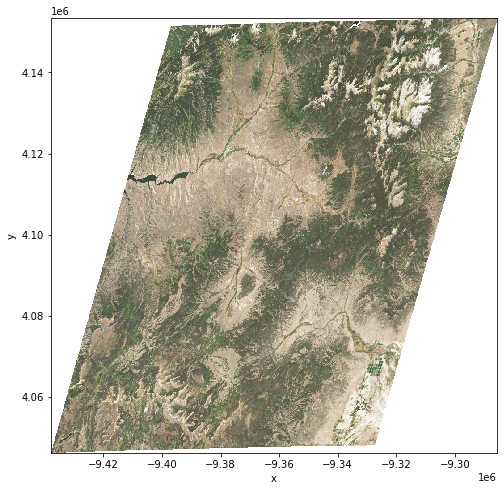

In [11]:
robinson_img = ms.true_color(*robinson_reproj, name="esri=54030")
robinson_img.plot.imshow(figsize=(8, 8));

### Method 3: Reproject and resample an in-memory array with [stackstac.reproject_array](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.reproject_array.html)

`stackstac.reproject_array` will reproject and clip an `xarray.DatArray` using [scipy.interpolate.interpn](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interpn.html) internally. To specify the resampling method, set the optional `interpolation` parameter to one of the two available interpolation methods: `linear` or `nearest` (default).

This example uses the [Space Oblique projection](https://en.wikipedia.org/wiki/Space-oblique_Mercator_projection) (EPSG: 29873). This projection was explicitly created for satellite imagery and is designed to be free of distortion along the orbit path of a satellite. For resampling, this example uses [linear interpolation](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.interpolate.interpn.html#scipy.interpolate.interpn) with a target resolution of `(100, 100)`.

**Step 1**: Use the [stackstac.array_bounds](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.array_bounds.html) function to get the bounds of your input data in the target CRS. The input data for this example is the DataArray called `scene_data` you created for the first method described in this notebook.

In [12]:
space_oblique_crs = 29873
space_oblique_bounds = stackstac.array_bounds(scene_data, space_oblique_crs)

space_oblique_bounds

(10675077.084681889, 9757187.124107027, 10823668.536491105, 9906913.424226366)

**Step 2**: Create a [RasterSpec](https://stackstac.readthedocs.io/en/latest/api/internal/stackstac.raster_spec.RasterSpec.html) object with the target CRS, the bounds from the previous step, and the target resolution. 

In [13]:
space_oblique_resolution = (100, 100)
space_oblique_spec = stackstac.raster_spec.RasterSpec(
    epsg=space_oblique_crs,
    bounds=space_oblique_bounds,
    resolutions_xy=space_oblique_resolution,
)

space_oblique_spec

RasterSpec(epsg=29873, bounds=(10675077.084681889, 9757187.124107027, 10823668.536491105, 9906913.424226366), resolutions_xy=(100, 100))

**Step 3**: Reproject and resample the data with `reproject_array`, using the DataArray `scene_data` and the RasterSpec from the previous step. This is also where you define the resampling method to be `"linear"`.

In [14]:
space_oblique_reproj = stackstac.reproject_array(
    arr=scene_data,
    spec=space_oblique_spec,
    interpolation="linear",
)

space_oblique_reproj

<xarray.DataArray 'stackstac-70964429577d6f8e4004178ae459a9c1' (band: 3, y: 1497, x: 1486)>
dask.array<dask_aware_interpnd, shape=(3, 1497, 1486), dtype=float64, chunksize=(1, 1497, 1486), chunktype=numpy.ndarray>
Coordinates: (12/48)
    time                                     datetime64[ns] 2019-09-24T17:50:...
    id                                       <U54 'S2B_MSIL2A_20190924T175049...
  * band                                     (band) <U3 'B04' 'B03' 'B02'
    s2:product_type                          <U7 'S2MSI2A'
    sat:orbit_state                          <U10 'descending'
    sat:relative_orbit                       int64 141
    ...                                       ...
    full_width_half_max                      (band) float64 0.038 0.045 0.098
    epsg                                     int64 6933
    x_6933                                   (y, x) float64 -1.025e+07 ... -1...
    y_6933                                   (y, x) float64 4.627e+06 ... 4.4...
  * y                                        (y) float64 9.907e+06 ... 9.757e+06
  * x                                        (x) float64 1.068e+07 ... 1.082e+07
Attributes:
    spec:        RasterSpec(epsg=6933, bounds=(-10353400, 4491300, -10229900,...
    crs:         epsg:6933
    transform:   | 100.00, 0.00,-10353400.00|\n| 0.00,-100.00, 4590800.00|\n|...
    resolution:  100

**Step 4**: Visualize the projection.

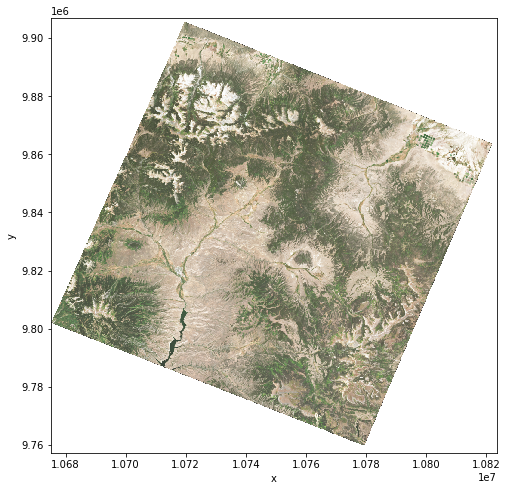

In [15]:
space_oblique_img = ms.true_color(*space_oblique_reproj, name="epsg=29873")
space_oblique_img.plot.imshow(figsize=(8, 8));

### Method 4: Reproject and resample an in-memory DataArray with [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) and [rioxarray](https://corteva.github.io/rioxarray/stable/)

[Rasterio](https://rasterio.readthedocs.io/en/latest/index.html) and [rioxarray](https://corteva.github.io/rioxarray/stable/) both provide tools for raster warping and reprojection. They both use [GDAL](https://gdal.org/) under the hood.

#### Reproject and resample in-memory data with rasterio's `reproject()`
The [WGS 84](https://en.wikipedia.org/wiki/World_Geodetic_System) projection (EPSG: 4326) is commonly used in many geodetic applications, including the Global Positioning System (GPS). WGS 84 displays meridians and parallels as equally spaced vertical and horizontal lines. Converting between x and y coordinates on the map and earth locations is very simple. This projection is very popular for general use. However, the significant distortions inherent to this method make it impractical for many scientific applications.

Follow these steps to use [rasterio.warp.reproject](https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html#rasterio.warp.reproject) to reproject your data to WGS 84 and resample it with the [median](https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling.med) resampling method.

**Step 1**: Get shape, CRS, bounds, and transform information from the source dataset and define the destination CRS. Similar to other methods that use `rasterio`, you can define a resampling method to use when reprojecting the data. To choose median resampling, set `med_resampling` to `rasterio.enums.Resampling.med`. This variable will later be used with the `resampling` parameter.

In [16]:
# source information
src_crs = {"init": scene_data.crs}
src_bounds = scene_data.rio.bounds()
src_transform = scene_data.transform
bands, src_height, src_width = scene_data.shape

# destination CRS
WGS84_crs = {"init": "EPSG:4326"}

# resampling method
med_resampling = rasterio.enums.Resampling.med

**Step 2**: Calculate the transform and shape of the destination CRS.

In [17]:
WGS84_transform, WGS84_width, WGS84_height = rasterio.warp.calculate_default_transform(
    src_crs, WGS84_crs, src_width, src_height, *src_bounds
)

# array to write results to
WGS84_data = np.zeros((bands, WGS84_height, WGS84_width))

WGS84_transform, WGS84_width, WGS84_height

(Affine(0.0010199914261785408, 0.0, -107.30489322500127,
        0.0, -0.0010199914261785408, 38.827024319904964),
 1255,
 970)

**Step 3**: Calculate the coordinates of the destination CRS.

In [18]:
WGS84_coords = _make_coords(
    scene_data, WGS84_transform, WGS84_width, WGS84_height, WGS84_crs
)

WGS84_xs = WGS84_coords["x"]
WGS84_ys = WGS84_coords["y"]

**Step 4**: Reproject and resample the source data to the destination CRS. Rasterio automatically calculates the target resolution.

In [19]:
rasterio.warp.reproject(
    scene_data,
    WGS84_data,
    src_transform=src_transform,
    src_crs=src_crs,
    dst_transform=WGS84_transform,
    dst_crs=WGS84_crs,
    resampling=med_resampling,
)

(array([[[554., 400., 400., ...,   0.,   0.,   0.],
         [554., 478., 404., ...,   0.,   0.,   0.],
         [680., 680., 462., ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]],
 
        [[493., 386., 386., ...,   0.,   0.,   0.],
         [493., 448., 392., ...,   0.,   0.,   0.],
         [610., 610., 427., ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]],
 
        [[309., 225., 225., ...,   0.,   0.,   0.],
         [309., 274., 225., ...,   0.,   0.,   0.],
         [407., 407., 255., ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]]]),
 Affine(0.001

**Step 5**: Reconstruct the result as an xarray DataArray.

In [20]:
WGS84_reproj = xr.DataArray(
    WGS84_data,
    dims=["band", "y", "x"],
    coords={"band": scene_data.band, "y": WGS84_ys, "x": WGS84_xs},
)

**Step 6**: Visualize the projection.

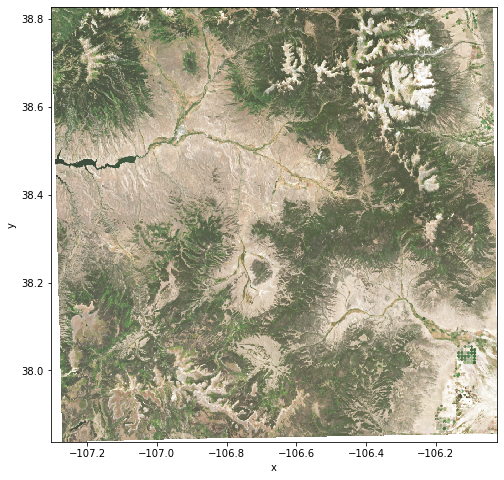

In [21]:
WGS84_img = ms.true_color(*WGS84_reproj, name="epsg=4326")
WGS84_img.plot.imshow(figsize=(8, 8));

#### Reproject and resample in-memory data with rioxarray's `reproject()`

The [Web Mercator](https://en.wikipedia.org/wiki/Web_Mercator_projection) projection is the de facto standard for Web mapping applications. It is a variant of the Mercator projection and is used by many major online map providers. [rioxarray's](https://corteva.github.io/rioxarray/stable/) [reproject function](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.raster_array.RasterArray.reproject) is powered by `rasterio.warp.reproject()`. Let's reproject your data from the CRS of `EPSG:6933` to the Web Mercator CRS of `EPSG:3857`.

Rioxarray's `reproject()` function accepts `resampling` and `resolution` as optional parameters. However, this example uses the library's defaults for resampling: The `reproject()` function uses the [nearest](https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling.nearest) method as its default resampling algoithm. If no resolution is provided, rioxarray calculates the resolution based on the source data and the target CRS.

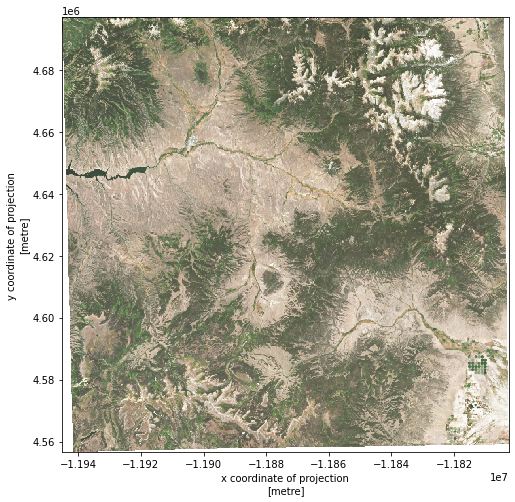

In [22]:
web_mecator_crs = 3857

web_mecator_reproj = scene_data.rio.reproject(web_mecator_crs)
web_mecator_img = ms.true_color(*web_mecator_reproj, name="epsg=3857")

web_mecator_img.plot.imshow(figsize=(8, 8));

### Wrap-up: Compare different reprojections

To see how reprojecting and resampling the same source dataset results in very different visualizations, plot all images side by side.

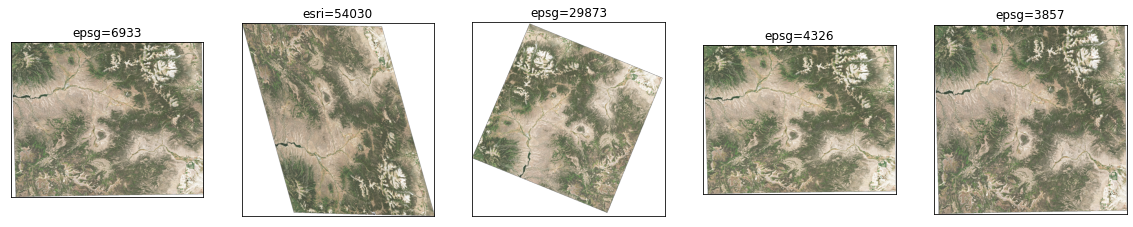

In [23]:
imgs = [cylindrical_img, robinson_img, space_oblique_img, WGS84_img, web_mecator_img]

fig, ax = plt.subplots(nrows=1, ncols=len(imgs), figsize=(20, 15))
for i in range(len(imgs)):
    ax[i].imshow(imgs[i].data)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(imgs[i].name)

plt.show()